### Курсовая работа. Классическое машинное обучение
### Раздел 3.3. Классификация: превышает ли значение SI медианное значение выборки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
# Загрузить данные
df = pd.read_csv('si.csv')
display(df.head())
print(df.shape)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,SI
0,-1.812779,1.202897,0.868409,-0.729005,1.094277,0.225177,-1.586455,1.520873,-2.063487,-0.593331,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,28.125
1,-2.159098,2.055029,0.960485,-0.517805,1.272861,0.256636,-1.789985,1.261644,-2.213061,-0.583101,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,7.000
2,-2.567062,2.109433,0.966363,-1.461422,1.036377,0.710135,-1.147686,1.103015,-2.400029,-0.557746,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,2.629564,-0.07706,0.720
3,-1.795530,0.524481,0.795104,-0.674338,0.593127,0.865439,-1.397847,1.993992,-2.242976,-0.592739,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,-0.140636,-0.07706,1.300
4,-1.609664,0.568684,0.799880,0.645806,-0.025219,-0.181798,-1.397847,0.149177,-0.735268,-0.593425,...,-0.221947,-0.091287,-0.091287,-0.034381,-0.034381,-0.247797,-0.281035,-0.140636,-0.07706,2.000


(847, 146)


In [ ]:
SEED = 42

In [ ]:
# Разделить данные на признаки и целевую переменную
X = df.drop('SI', axis=1)
y = df['SI']

# Разделить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

# Получить медианное значение целевой переменной
MEDIAN = y_train.median()

Train dataset size: (592, 145), (592,)
Train dataset size: (255, 145), (255,)


Условием настоящей задачи является определение, превысит ли значение целевой переменной ее медианное значение. В конечном итоге перед нами стоит задача классификации с двумя возможными метками класса - превысит или нет.

In [5]:
y_train = (y_train > MEDIAN).astype(int)
y_test = (y_test > MEDIAN).astype(int)

C:\Users\Ronikari\AppData\Local\Temp\ipykernel_15596\2116491072.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SI', data=y_data, palette='hls')


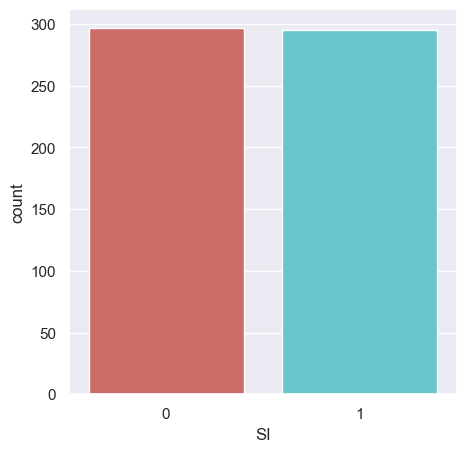

In [23]:
# Проанализировать распределение меток класса
sns.set(rc = {'figure.figsize':(5, 5)})
y_data = pd.DataFrame(y_train)
sns.countplot(x='SI', data=y_data, palette='hls')
plt.show()

В рамках настоящей задачи будем использовать следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
Для анализа эффективности моделей проверим следующие метрики:
- Accuracy;
- Precision;
- F1;
- Recall.

In [6]:
# Инициализация моделей и метрик
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}
metrics = {
    'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

In [7]:
# Создать список для хранения результатов
results = []

In [8]:
for name, model in models.items():
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить модель на обучающей выборке и сделать прогноз на тестовой выборке
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

In [9]:
# Записать результаты в DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
4,SVC,0.5929,0.6014,0.5708,0.5458,0.6627,0.7203,0.6641,0.6159
0,LogisticRegression,0.5591,0.5582,0.5549,0.5559,0.6235,0.6544,0.6496,0.6449
3,KNN,0.5608,0.5535,0.5821,0.6169,0.6157,0.6389,0.6525,0.6667
2,RandomForest,0.5878,0.5883,0.5778,0.5695,0.6118,0.6612,0.6178,0.5797
6,CatBoost,0.5811,0.5806,0.5725,0.5661,0.6078,0.6462,0.6269,0.6087
5,XGBoost,0.5557,0.5547,0.5473,0.5424,0.5922,0.6417,0.5969,0.5580
1,DecisionTree,0.5962,0.6073,0.5646,0.5322,0.5765,0.6415,0.5574,0.4928


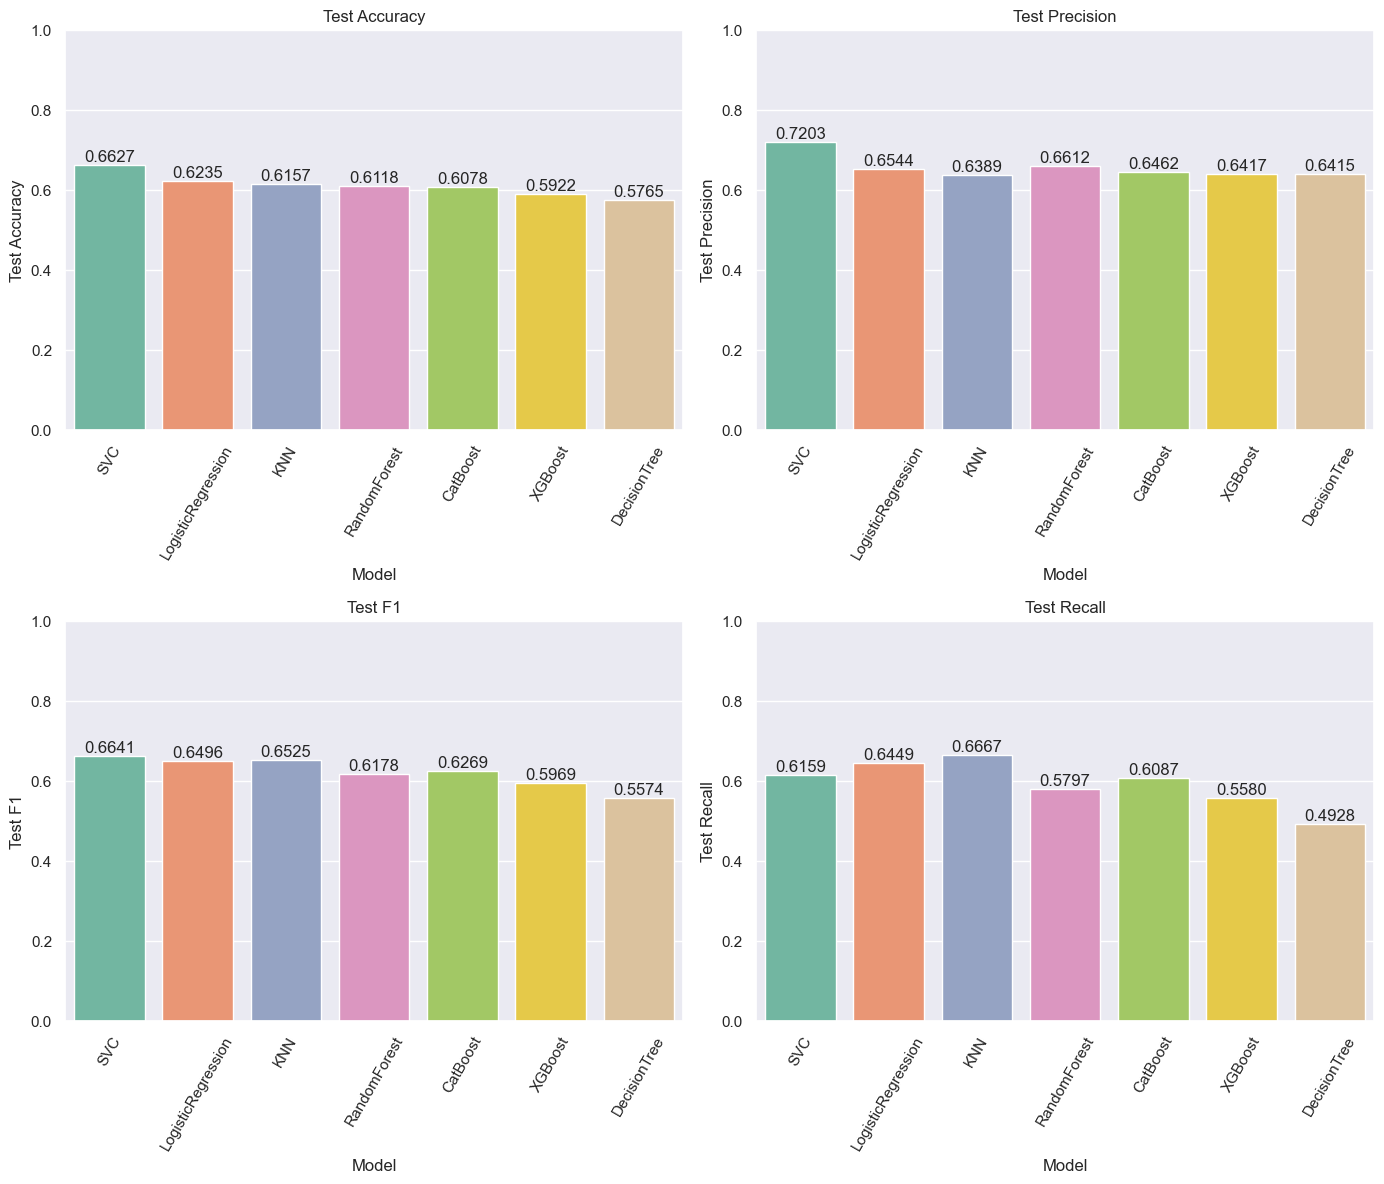

In [25]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

По совокупности полученных метрик наиболее эффективной моделью является `RandomForest`.   
Теперь используем `GridSearchCV` и подберем наиболее оптимальные гиперпараметры для всех моделей, после чего перепроверим метрики.

In [11]:
# Конфигурация гиперпараметров для GridSearchCV
params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 250, 500, 1000]
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': [None, 5, 10, 20]
    },
    'CatBoost': {
        'n_estimators': [50, 100, 200, 400, 500, 1000]
    }
}

# Повторная инициализация моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}

In [12]:
# Создать список для хранения результатов
results_grid = []

# Создать словарь для хранения предсказанных значений
pred_values = {}

In [13]:
for name, model in models.items():
    # Запустить поиск лучших гиперпараметров
    grid = GridSearchCV(model, param_grid=params[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Лучшая модель
    best_model = grid.best_estimator_
    print(f'Лучшие параметры для {name}: {grid.best_params_}')
    
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить и оценить качество лучшей модели на тестовой выборке
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    pred_values[name] = y_pred
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results_grid.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

Лучшие параметры для LogisticRegression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Лучшие параметры для DecisionTree: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Лучшие параметры для RandomForest: {'max_depth': 4, 'n_estimators': 100}
Лучшие параметры для KNN: {'metric': 'manhattan', 'n_neighbors': 7}
Лучшие параметры для SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Лучшие параметры для XGBoost: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
Лучшие параметры для CatBoost: {'n_estimators': 50}


In [14]:
# Записать результаты в DataFrame
results_grid_df = pd.DataFrame(results_grid)
results_grid_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_grid_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
3,KNN,0.5844,0.5758,0.6053,0.6407,0.6471,0.6714,0.6763,0.6812
0,LogisticRegression,0.5827,0.5802,0.5816,0.5864,0.6392,0.6825,0.6515,0.6232
2,RandomForest,0.6115,0.6310,0.5779,0.5356,0.6353,0.6891,0.6381,0.5942
5,XGBoost,0.6047,0.6072,0.5954,0.5864,0.6157,0.6587,0.6288,0.6014
6,CatBoost,0.6064,0.6119,0.5907,0.5729,0.6118,0.6489,0.6320,0.6159
1,DecisionTree,0.5997,0.6173,0.5666,0.5288,0.6078,0.6759,0.5935,0.5290
4,SVC,0.6064,0.7024,0.4758,0.3627,0.5961,0.7465,0.5072,0.3841


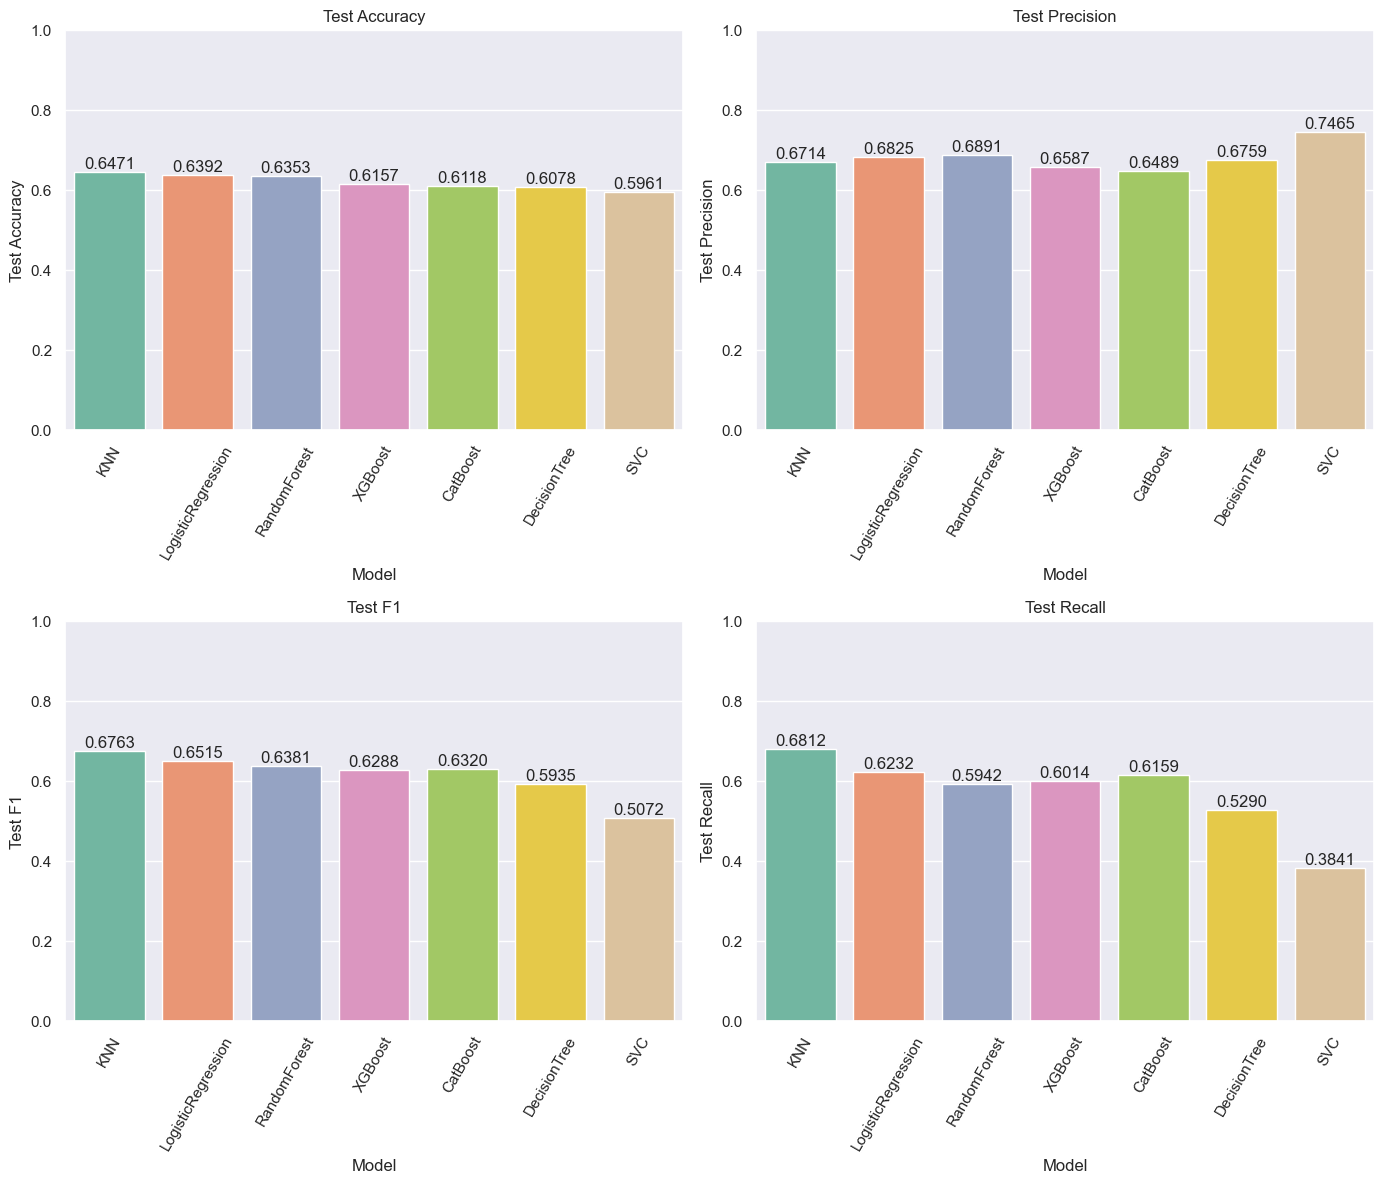

In [26]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_grid_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

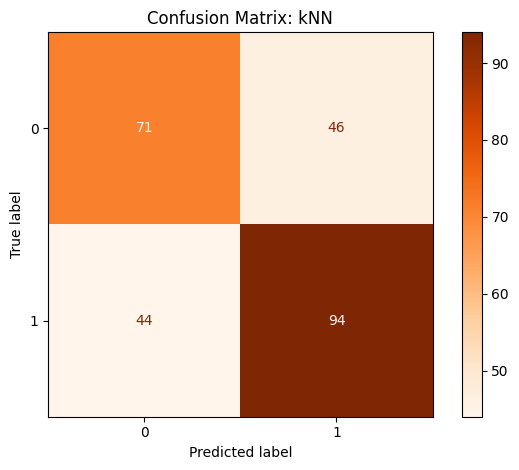

In [ ]:
# Построить матрицы ошибок для лучшей модели
cm_knn = confusion_matrix(y_test, pred_values['KNN'])

plt.figure(figsize=(10, 4))
cm_display = ConfusionMatrixDisplay(cm_knn)
cm_display.plot(cmap='Oranges')

plt.title('Confusion Matrix: kNN')

plt.tight_layout()
plt.show()

По совокупности полученных метрик и с подбором гиперпараметров посредством `GridSearchCV` наиболее эффективной моделью является `kNN`.   

**Выводы**  
  
1. В рамках настоящей задачи были использованы следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
   Наиболее оптимальной моделью по совокупности использованных метрик принимается `kNN`.
2. Метрики всех моделей оказались приемлемыми. В качестве рекомендаций по дальнейшему улучшению предсказательной способности моделей требуется более глубокая обработка исходных данных. Как показал ранее выполненный EDA, в данных присутствует существенное число выбросов, однако для их эффективного устранения требуется знание специфики отрасли и понимание ключевой важности тех или иных признаков, что не было выполнено в настоящей работе.